F1-score for MLP: 0.9171347372516699
F1-score for Random Forest: 0.9466349727911615
F1-score for Logistic Regression: 0.8666242146040508


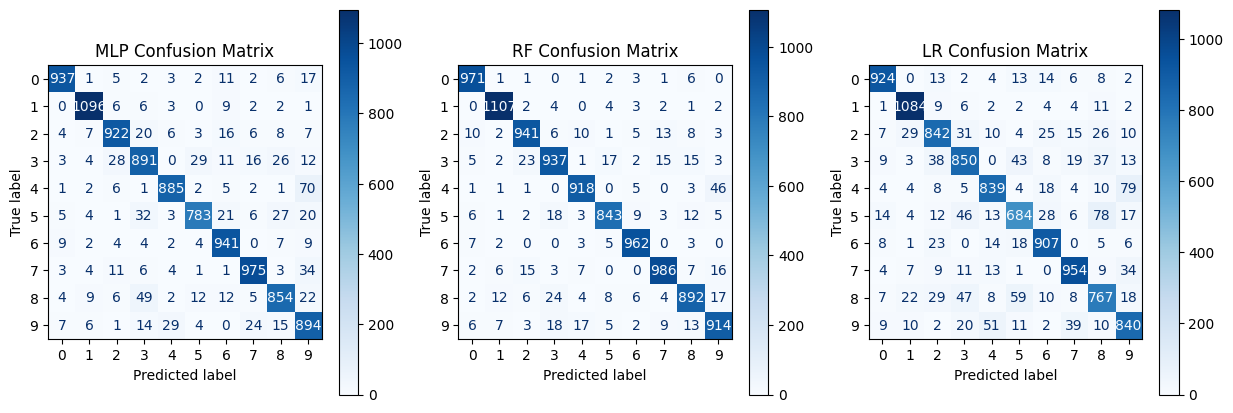

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Set up the generator with a specific seed
g = torch.Generator()
g.manual_seed(4000002)

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"].astype(np.int8)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, stratify=y, random_state=42)

# Smaller subset for faster training
X_train_small, _, y_train_small, _ = train_test_split(X_train, y_train, train_size=10000, stratify=y_train, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_small.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_small.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create datasets and loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=g)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

# Define the MLP Model
class MLP(nn.Module):
    def __init__(self, generator):
        super(MLP, self).__init__()
        self.hidden_layer1 = nn.Linear(28*28, 30)
        self.hidden_layer2 = nn.Linear(30, 20)
        self.output_layer = nn.Linear(20, 10)
        self._initialize_weights(generator)

    def _initialize_weights(self, generator):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')  # Using Kaiming He initialization
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.output_layer(x)
        return x

# Create an instance of the model
model = MLP(generator=g)
untrained_model = MLP(generator=g)

# Step 4: Training the MLP model
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Switch to Adam optimizer
criterion = nn.CrossEntropyLoss()

def train(model, train_loader, epochs=5000):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

# Train the model
train(model, train_loader, epochs=1000)

# Step 5: Evaluate the MLP model
model.eval()
with torch.no_grad():
    y_pred_mlp = model(X_test_tensor)
    y_pred_mlp = y_pred_mlp.argmax(dim=1).cpu().numpy()

# Step 6: Compare against RandomForest and LogisticRegression from scikit-learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_small, y_train_small)
y_pred_rf = rf.predict(X_test)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_small, y_train_small)
y_pred_lr = lr.predict(X_test)

# Step 7: Compute F1-scores
f1_mlp = f1_score(y_test, y_pred_mlp, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
f1_lr = f1_score(y_test, y_pred_lr, average='macro')

print(f"F1-score for MLP: {f1_mlp}")
print(f"F1-score for Random Forest: {f1_rf}")
print(f"F1-score for Logistic Regression: {f1_lr}")

# Step 8: Confusion matrices
cm_mlp = confusion_matrix(y_test, y_pred_mlp)
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ConfusionMatrixDisplay(cm_mlp).plot(ax=axes[0], cmap='Blues')
axes[0].set_title('MLP Confusion Matrix')
ConfusionMatrixDisplay(cm_rf).plot(ax=axes[1], cmap='Blues')
axes[1].set_title('RF Confusion Matrix')
ConfusionMatrixDisplay(cm_lr).plot(ax=axes[2], cmap='Blues')
axes[2].set_title('LR Confusion Matrix')
plt.show()


##In MLP model, the below are the mostly confused scenarios:
####3 and 5:
 29 instances of '3' predicted as '5'.
32 instances of '5' predicted as '3'.
####9 vs 4:
 29 instances of '9' predicted as '4'.
70 instances of '4' predicted as '9'.
####0 vs 6:
 11 instances of '0' predicted as '6'.
9 instances of '6' predicted as '0'.



##In randomforest model, the below are the mostly confused scenarios:
####3 and 5:
 17 instances of '3' predicted as '5'.
18 instances of '5' predicted as '3'.
####9 vs 4:
 17 instances of '9' predicted as '4'.
46 instances of '4' predicted as '9'.
####0 vs 6:
 11 instances of '0' predicted as '6'.
9 instances of '6' predicted as '0'.


##In logisticregression model, the below are the mostly confused scenarios:
####3 and 5:
 43 instances of '3' predicted as '5'.
46 instances of '5' predicted as '3'.
####9 vs 4:
 51 instances of '9' predicted as '4'.
79 instances of '4' predicted as '9'.
####0 vs 6:
 14 instances of '0' predicted as '6'.
8 instances of '6' predicted as '0'.


Commonly confused are (9,4), (5,3), (0,6) across all three classifiers.

In our case,
MLP Model:

The MLP model generally performs well, showing fewer confusions compared to Logistic Regression model. Most diagonal entries have higher counts, indicating more correct classifications.

Random Forest (RF) Model:

The RF model has fewer errors compared to MLP and Logistic Regression model in many cases.


Logistic Regression (LR) Model:

Logistic Regression struggles the most compared to MLP and RF.

MLP is better at capturing complex, nonlinear patterns(activation function ReLU), leading to fewer confusions but still struggles with very similar digits.
The performance of mlp model can be increased be increasing the number of epochs, standardising input data, increasing hidden layers, finding the efficient learning rate.



Random Forest, not explicitly non-linear but benefits from the ensemble of trees, and capture more detail than a single linear model leading to less confusion in general, but may still confuse subtle differences in digit shapes.

Logistic Regression has the highest confusion in our case because of its linearity, which makes it unable to handle the complex variations in the MNIST digits.

MLP learns feature interactions implicitly through backpropagation. It doesn't require manual feature engineering and can automatically learn the importance of various pixel combinations, which helps in resolving some digit confusions.
Random Forests also implicitly handles feature interactions, but in a different way. Each decision tree considers different feature subsets, and by averaging across many trees, Random Forest can model interactions reasonably well. However, since each tree is a "weak learner," it may still lead to confusion in some cases.
Logistic Regression assumes independence between features and doesn’t model feature interactions well, leading to higher confusion rates.

Here the confused digits are wriiten similar to each other. So this can make it slightly difficult to the model to predict the correct class.

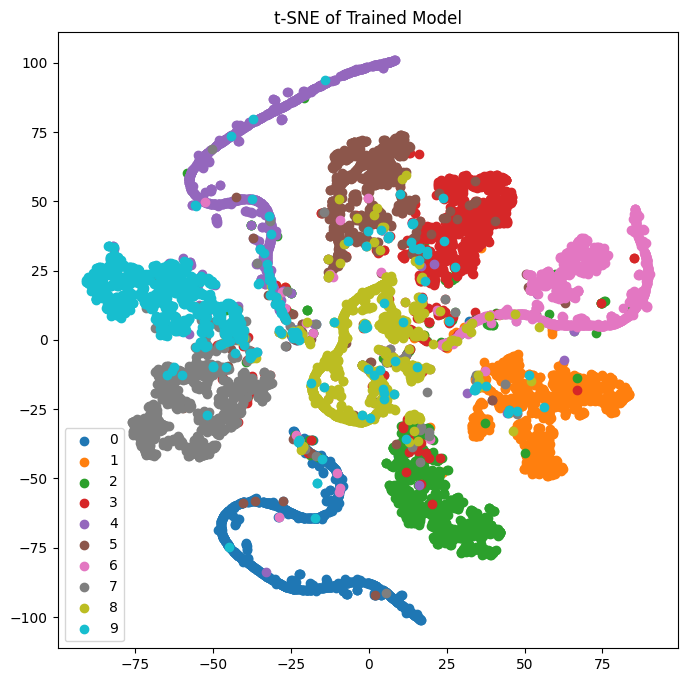

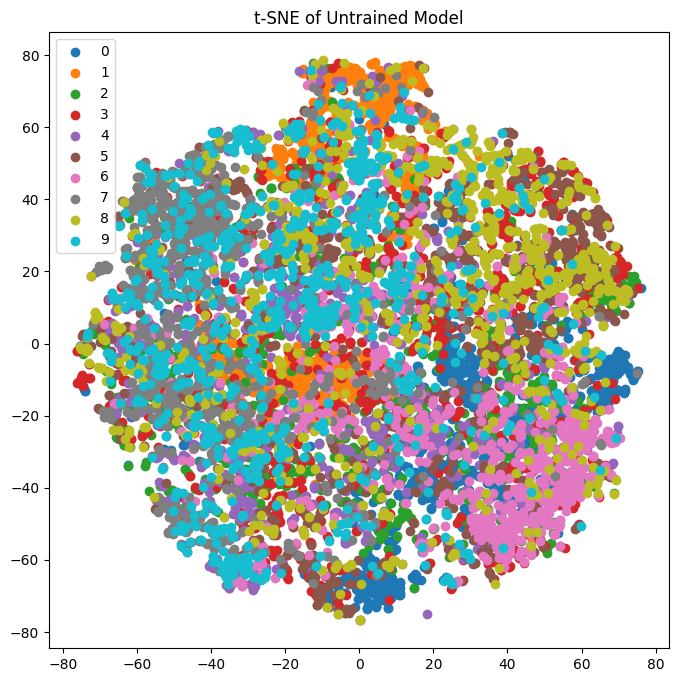

In [3]:
from sklearn.manifold import TSNE

untrained_model = MLP(generator=g)

# Extract features from the second hidden layer
def get_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.view(-1, 28*28)
            hidden_output = torch.relu(model.hidden_layer1(images))
            second_hidden_output = torch.relu(model.hidden_layer2(hidden_output))
            features.append(second_hidden_output)
            labels.append(lbls)
    return torch.cat(features).numpy(), torch.cat(labels).numpy()

# Get features for trained and untrained models
trained_features, trained_labels = get_features(model, test_loader)
untrained_features, untrained_labels = get_features(untrained_model, test_loader)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
trained_tsne = tsne.fit_transform(trained_features)
untrained_tsne = tsne.fit_transform(untrained_features)

# Plotting t-SNE
def plot_tsne(tsne_data, labels, title):
    plt.figure(figsize=(8, 8))
    for i in range(10):
        indices = (labels == i)
        plt.scatter(tsne_data[indices, 0], tsne_data[indices, 1], label=str(i))
    plt.legend()
    plt.title(title)
    plt.show()

plot_tsne(trained_tsne, trained_labels, "t-SNE of Trained Model")
plot_tsne(untrained_tsne, untrained_labels, "t-SNE of Untrained Model")

Observations from the Trained Model t-SNE:
Cluster Separation: Most digits have formed separate, well-defined clusters. This indicates that the MLP's second hidden layer (with 20 neurons) has learned effective representations for distinguishing between the digits.
Minimal Overlap: There is some overlap in regions, but most digits are clearly separable. This can be due to the misclassified digits might be written similar to other digits.

Untrained Model (First Plot):

In the untrained model, the points for different digits are scattered randomly without any clear separation between the classes. The representations will appear random because the weights in the MLP have not yet been adjusted to capture patterns in the data. There will be no structure linking similar digits together. The lack of clustering suggests that the model has not learned to differentiate between the different digits, which is expected since it hasn't been trained.



In [ ]:
def load_data(name, test_size=10000):
    dataset = fetch_openml(name, version=1)
    X, y = dataset["data"], dataset["target"].astype(np.int8)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
    return X_train, X_test, y_train, y_test



# Load Fashion-MNIST dataset
X_fashion_train, X_fashion_test, y_fashion_train, y_fashion_test =load_data('Fashion-MNIST')

# Convert Fashion-MNIST data to PyTorch tensors
X_fashion_test_tensor = torch.tensor(X_fashion_test.values, dtype=torch.float32)
y_fashion_test_tensor = torch.tensor(y_fashion_test.values, dtype=torch.long)

# Create Fashion-MNIST test dataset and loader
fashion_test_dataset = TensorDataset(X_fashion_test_tensor, y_fashion_test_tensor)
fashion_test_loader = DataLoader(fashion_test_dataset, batch_size=10000, shuffle=False)

# Extract features for Fashion-MNIST
fashion_features, fashion_labels = get_features(model, fashion_test_loader)

# Perform t-SNE for Fashion-MNIST
fashion_tsne = tsne.fit_transform(fashion_features)

# Plot t-SNE for Fashion-MNIST
plot_tsne(fashion_tsne, fashion_labels, "t-SNE of Fashion-MNIST using Trained Model")

###MNIST(Digits):

In the MNIST dataset, the trained model's embeddings show clear and distinct clusters for each digit (0-9). Each cluster is well-separated, indicating that the features learned by the model allow it to strongly differentiate between the digits. This is expected since the MNIST digit dataset has well-defined, simple shapes for each class (digits), making classification relatively easier.


###Fashion-MNIST:

In the t-SNE visualization for Fashion-MNIST, the clusters are more interspersed, and the separation between classes is not as clear as it was for MNIST. There are some groups (e.g., for classes 0 and 9) that seem to have better separation, but many other classes overlap significantly.
Fashion-MNIST contains images of clothing items (e.g., t-shirts, trousers, sneakers), which are much more visually complex compared to digits. As a result, distinguishing between different classes is harder, leading to more overlap in the embeddings.
The more intertwined nature of the embeddings suggests that the features learned by the model do not perfectly separate classes, which aligns with the fact that visual distinctions between clothing items can be more compared to the simple digit structures in MNIST.